# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

We used the [2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), which consists of pickup and dropoff coordinates for trips, along with metadata like cost, distance, and number of passengers. Columns we expect to find especially useful are those that could affect the time to destination, but obviously are not known in advance of the trip.

Since our dataset was tremendous (2 million trips) we needed to segment the data by borough and neighborhood to test different forms of inference. We downloaded a shapefile from [NYC Planning](http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page) and added the neighborhoods of both pickup and dropoff to the dataset. This was a costly process which we then found had already been done and was available online, remember to always google first.

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")

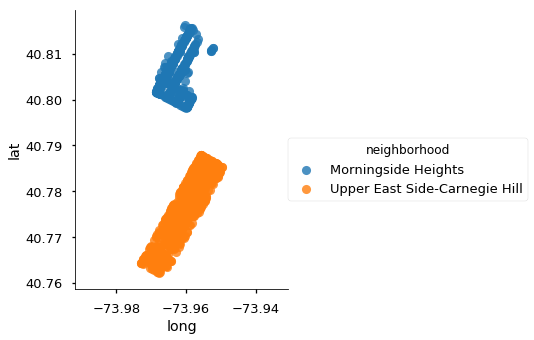

In [3]:
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
visualizations.visualize_by_borough(ues_to_msh)
plt.show()

In [4]:
indicator_cols = ["pickup_latitude",
                  "pickup_longitude",
                  "dropoff_latitude",
                  "dropoff_longitude",
                  "manhattan_distance",
                  "pickup_hour",
                  "pickup_timestamp"]

y_cols = ["trip_duration"]

poly_degree = 4

x_train_glm_raw, y_train_glm_raw, x_test_glm_raw, y_test_glm_raw = data.train_test_split(ues_to_msh,
                                                         0.2,
                                                         indicator_cols,
                                                         y_cols)
x_train_standardized_glm = data.standardize_cols(x_train_glm_raw)
x_test_standardized_glm = data.standardize_cols(x_test_glm_raw)

x_train_glm = basis_functions.polynomial(x_train_standardized_glm, degree = poly_degree)
x_test_glm = basis_functions.polynomial(x_test_standardized_glm, degree = poly_degree)

vis = x_train_glm_raw.copy(deep=True)
vis["trip_duration"] = y_train_glm_raw.copy(deep=True)

# Model

In [5]:
N, D = x_train_glm.shape
X = tf.placeholder(tf.float32, [N, D], name="linear_model_X")
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D), name="linear_model_w")
b = ed.models.Normal(loc=[0.0], scale=1.0, name="linear_model_b")
alpha = ed.models.Normal(loc=[0.0], scale=1.0, name="linear_model_alpha")
Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=alpha, name="linear_model_Y")

qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([1])),
                                                   tf.Variable(tf.zeros([1]))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb, alpha: qalpha},
                    data={X: x_train_glm.as_matrix(),
                          Y: np.reshape(y_train_glm_raw.as_matrix(), (y_train_glm_raw.shape[0]))})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 2327.383


# Critique

## Graph The Prediction

The graph below is a prediction of our data solely as a function of pickup hour, meaning that all other points are held to their mean values as expected by the linear model, i.e. 0.

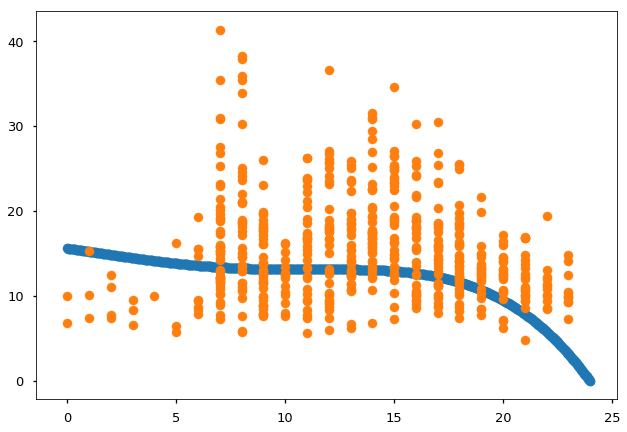

In [6]:
def vis_glm(num_pnts, indicator_cols, actual_data, qw, qb, qalpha):
    times = np.linspace(0, 24, num_pnts)
    x_vis = pd.DataFrame({i: [0.0] * num_pnts for i in indicator_cols})
    x_vis["pickup_hour"] = times
    x_vis["pickup_timestamp"] = x_vis["pickup_hour"].apply(lambda x: pd.to_datetime(x, unit="s").hour)
    x_vis_stndzd = data.standardize_cols(x_vis)
    qw_i = qw.sample().eval()
    qb_i = qb.sample().eval()
    qalpha_i = qalpha.sample().eval()

    x_vis_poly = basis_functions.polynomial(x_vis_stndzd, degree=poly_degree).fillna(0.0)
    line = np.matmul(x_vis_poly, qw_i) + qb_i + qalpha_i

    plt.scatter(x=times, y=line)
    plt.scatter(x=actual_data["pickup_hour"], y=actual_data["trip_duration"])
    plt.show()
vis_glm(1000, indicator_cols, vis, qw, qb, qalpha)

In [7]:
N, D = x_test_glm.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_glm_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, w) + b, scale=alpha)
print(ed.evaluate("mean_absolute_error",
            data={X_eval: x_test_glm.as_matrix(),
                  y_glm_posterior_predictive: np.reshape(y_test_glm_raw.as_matrix(), (y_test_glm_raw.shape[0])),
                  w: qw,
                  b: qb,
                  alpha: qalpha
                 },
             output_key=y_glm_posterior_predictive))

14.4559


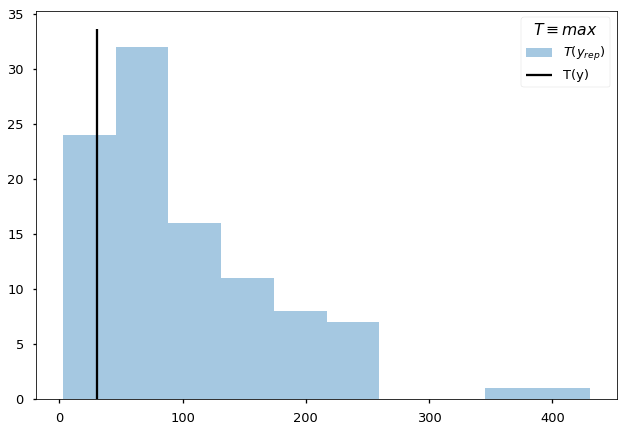

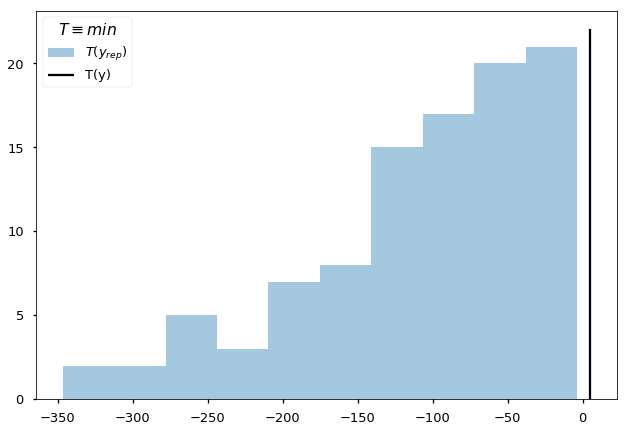

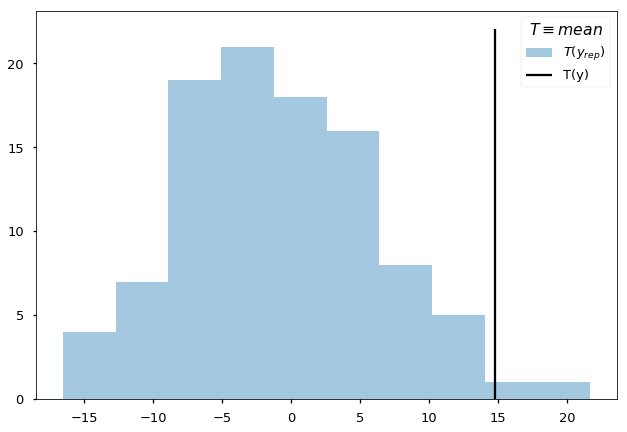

In [8]:
def T_max(data_dict, latent_vars_dict):
    return tf.reduce_max(data_dict[y_glm_posterior_predictive])
def T_min(data_dict, latent_vars_dict):
    return tf.reduce_min(data_dict[y_glm_posterior_predictive])
def T_mean(data_dict, latent_vars_dict):
    return tf.reduce_mean(data_dict[y_glm_posterior_predictive])
ppc_stats_max = ed.ppc(T_max,
                             data={
                                 X_eval: x_test_glm.as_matrix(),
                                 y_glm_posterior_predictive: np.reshape(y_test_glm_raw.as_matrix(), (y_test_glm_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )
ppc_stats_min = ed.ppc(T_min,
                             data={
                                 X_eval: x_test_glm.as_matrix(),
                                 y_glm_posterior_predictive: np.reshape(y_test_glm_raw.as_matrix(), (y_test_glm_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )
ppc_stats_mean = ed.ppc(T_mean,
                             data={
                                 X_eval: x_test_glm.as_matrix(),
                                 y_glm_posterior_predictive: np.reshape(y_test_glm_raw.as_matrix(), (y_test_glm_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb, alpha: qalpha }
                      )

ed.ppc_stat_hist_plot(ppc_stats_max[1][1], ppc_stats_max[0], stat_name=r'$T \equiv max$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_min[1][1], ppc_stats_min[0], stat_name=r'$T \equiv min$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_mean[1][1], ppc_stats_mean[0], stat_name=r'$T \equiv mean$',
    bins=10)
plt.show()

### Results of a Linear Model
TODO

# Gaussian Process

Lets try a different route. 

In [9]:
x_harlem_to_bat_park = data.get_neighborhood_to_neighborhood("East Harlem North", "Battery Park City-Lower Manhattan", manhattan)
x = data.get_neighborhood_to_neighborhood("Battery Park City-Lower Manhattan", "East Harlem North", manhattan)
harlem_to_bat_park = pd.concat([x_harlem_to_bat_park, x])

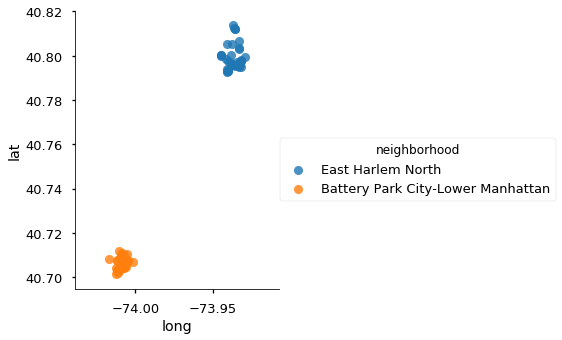

In [10]:
indicator_cols = ["pickup_latitude",
                  "pickup_longitude",
                  "dropoff_latitude",
                  "dropoff_longitude",
                  "manhattan_distance",
                  "pickup_hour",
                  "pickup_timestamp"]


y_cols = ["trip_duration"]

x_train_harlem_to_bat_park, y_train_harlem_to_bat_park, x_test_harlem_to_bat_park, y_test_harlem_to_bat_park = data.train_test_split(harlem_to_bat_park,
                                                         0.2,
                                                         indicator_cols,
                                                         y_cols)
x_train_standardized_harlem_to_bat_park = data.standardize_cols(x_train_harlem_to_bat_park)
x_test_standardized_harlem_to_bat_park = data.standardize_cols(x_test_harlem_to_bat_park)

visualizations.visualize_by_borough(harlem_to_bat_park)
plt.show()

In [11]:
n_test, d_test = x_test_harlem_to_bat_park.shape
y_n, y_d = y_train_harlem_to_bat_park.shape
N, D = x_train_harlem_to_bat_park.shape

x_test_gp = tf.placeholder(tf.float32, [n_test, d_test])
x_gp = tf.placeholder(tf.float32, [N, D])
y_gp = tf.placeholder(tf.float32, [y_n, y_d])

mu, var = tf.nn.moments(y_gp, 1)

v_i = tf.eye(N) * var

k = ed.rbf(x_gp, lengthscale=0.9996, variance=1.0) + v_i

k_star = ed.rbf(x_test_gp, x_gp)

k_star_star = ed.rbf(x_test_gp)

k_inv = tf.matrix_inverse(k)

mu_star = tf.matmul(tf.matmul(k_star, k_inv), y_gp)

tmp1 = tf.matmul(k_star, k_inv)

tmp2 = tf.matmul(tmp1, k_star, transpose_b=True)

v_star = k_star_star - tmp2

L = tf.cholesky(tf.abs(v_star))

p_y = ed.models.MultivariateNormalTriL(loc=mu_star, scale_tril=tf.abs(L))

expected = mu_star.eval(session=tf.Session(), feed_dict={
    x_gp: x_train_standardized_harlem_to_bat_park.as_matrix(),
    y_gp: y_train_harlem_to_bat_park.as_matrix(),
    x_test_gp: x_test_standardized_harlem_to_bat_park.as_matrix()
})

print("actual")
print(expected)
print("expected")
print(y_test_harlem_to_bat_park)
print("error")
err = y_test_harlem_to_bat_park - expected
print(np.abs(err))
print("mean abs error")
print(np.abs(err).mean())

actual
[[  6.62533855]
 [ 19.30910301]
 [ 19.33669662]
 [ 18.00264359]
 [ 10.97401714]
 [ 20.59525871]
 [  6.13930845]]
expected
    trip_duration
3       19.733333
27      22.166667
21      18.033333
25      17.250000
19      20.500000
20      20.200000
7       17.800000
error
    trip_duration
3       13.107995
27       2.857564
21       1.303363
25       0.752644
19       9.525983
20       0.395259
7       11.660692
mean abs error
trip_duration   5.657643
dtype: float64


# TODO This is useless unless it does better than GLM for ues_msh data...\